# Image Stitching (Python)

## Usage
This code snippet provides an overall code structure and some interactive plot interfaces for the Stitching Pairs of Images section of MP 3. In main function, we outline the required functionalities step by step. Feel free to make modifications on the starter code if it's necessary.

## Package installation
- `opencv`
- `numpy`
- `skimage`
- `scipy`

# Common imports

In [1]:
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy
from skimage.transform import ProjectiveTransform, warp,resize


# Helper functions

In [3]:
def imread(fname):
    """
    read image into np array from file
    """
    return skimage.io.imread(fname)

def imread_bw(fname):
    """
    read image as gray scale format
    """
    return cv2.cvtColor(imread(fname), cv2.COLOR_BGR2GRAY)

def imshow(img):
    """
    show image
    """
    skimage.io.imshow(img)
    
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

# Your implementations

In [4]:
def get_best_matches(img1, img2, threshold = 0.03):
    #I choose the select  threshold, because this is easier..
    kp1, des1 = get_sift_data(img1)
    kp2, des2 = get_sift_data(img2)
    kp1, kp2 = np.array(kp1), np.array(kp2)
    
    # Find distance between descriptors in images
    dist = scipy.spatial.distance.cdist(des1, des2, 'sqeuclidean')
    
    # Write your code to get the matches according to dist
    # <YOUR CODE>
    matches = dist/ dist.max() < threshold 
    match_points = np.nonzero(matches)
    inliers = np.zeros((len(match_points[0]), 4))

    for i, match_idx in enumerate(zip(*match_points)):
        inliers[i] = [*kp1[match_idx[0]].pt, *kp2[match_idx[1]].pt]
        
    return inliers

def ransac(data, distance_threshold=2, outlier_ratio=0.2):
    """
    write your ransac code to find the best model, inliers, and residuals
    """
    # <YOUR CODE>
    p = 0.99
    s = 4
    e = outlier_ratio
    N = int(np.log(1 - p) / np.log(1 - e ** s))

    X = data[:, :2]
    X_match = data[:, 2:]
    X_h = np.ones((data.shape[0], 3))
    X_h[:, :2] = X

    best_h = None
    best_inliers = None
    best_residuals = None

    for i in range(N):
        # Sample s points from the data
        samples_idx = np.random.choice(data.shape[0], size=s, replace=False)
        samples = data[samples_idx]
        h = compute_homography(samples)
        h = h.reshape((3, 3))
        
        # Calculate inlier/outlier correspondences
        projected = np.dot(h, X_h.T)
        projected /= projected[-1, :]
        projected = projected[:2, :].T
        residuals = np.linalg.norm(projected - X_match, axis=1)
        inlier_mask = residuals <= distance_threshold
        outlier_mask = np.logical_not(inlier_mask)
        inliers = data[inlier_mask]
        residuals_inliers = residuals[inlier_mask]
        
        # If this is the best model found so far, store it
        if best_h is None or len(inliers) > len(best_inliers):
            best_h = compute_homography(inliers).reshape((3, 3))
            best_inliers = inliers
            best_residuals = residuals_inliers
            
        # Check if the number of outliers is below the threshold
        if len(outlier_mask) / len(data) < e:
            break

    if best_h is None:
        raise ValueError("Failed to find a good model!")

    return best_h, best_inliers, best_residuals

def compute_homography(matches):
    """
    write your code to compute homography according to the matches
    """
    # <YOUR CODE>
    num_matches = matches.shape[0]
    A = np.zeros((2*num_matches, 9))
    for i, match in enumerate(matches):
        x1, y1, x2, y2 = match
        A[2*i, :] = np.array([-x1, -y1, -1, 0, 0, 0, x2*x1, x2*y1, x2])
        A[2*i+1, :] = np.array([0, 0, 0, -x1, -y1, -1, y2*x1, y2*y1, y2])
    _, _, V_T = np.linalg.svd(A)
    H = V_T[-1, :].reshape(3, 3)
    return H / H[2, 2]




def create_coordinates(width, height):
    coord_y, coord_x = np.indices((height, width))
    coord_x = np.expand_dims(coord_x, axis=-1)
    coord_y = np.expand_dims(coord_y, axis=-1)
    ones = np.ones_like(coord_x)
    return np.concatenate((coord_x, coord_y, ones), axis=-1).T


def warp_images(image1, image2, homography_matrix):
    """
    write your code to stitch images together according to the homography
    """
    # <YOUR CODE>
# Calculate the output shape by considering the corner points of the images
    img_height, img_width, _ = image1.shape
    coordinates = create_coordinates(img_width, img_height)
    transformed = np.zeros_like(coordinates)
    for i in range(coordinates.shape[-1]):
        transformed[:, :, i] = np.dot(homography_matrix, coordinates[:, :, i])
    transformed = transformed.astype(np.float64)
    transformed /= transformed[2, :, :]
    transformed = transformed[:2, :, :].astype(int)

    x1_vals = transformed[0, :, :]
    y1_vals = transformed[1, :, :]

    min_x = min(0, x1_vals.min())
    min_y =  min(0, y1_vals.min())
    max_x = max(img_width, x1_vals.max())
    max_y = max(img_height, y1_vals.max())

    transformed[0, :, :] += abs(min_x)
    transformed[1, :, :] += abs(min_y)
    new_height = max_y - min_y + 1
    new_width = max_x - min_x + 1
    original_coords = create_coordinates(new_width, new_height)
    original_coords[0, :, :] += min_x
    original_coords[1, :, :] += min_y
    original_coords = np.tensordot(np.linalg.inv(homography_matrix), original_coords, 1)
    original_coords /= original_coords[-1, :, :]
    original_coords = original_coords[:2, :, :].astype(int)
    result_image = np.zeros((new_height, new_width, 3)) + 255.
    result_image[abs(min_y): abs(min_y) + img_height, abs(min_x): abs(min_x) + img_width] = image2

    for x in range(new_width - 1):
        for y in range(new_height - 1):
            x0, y0 = original_coords[:, x, y]
            if 0 <= x0 < img_width and 0 <= y0 < img_height:
                result_image[y, x, :] = image1[y0, x0, :]

    return result_image
 

# Main functions

#### Load images

In [5]:
img1 = imread('./stitch/left.jpg')
img2 = imread('./stitch/right.jpg')

#### Part (3) compute and display the initial SIFT matching result

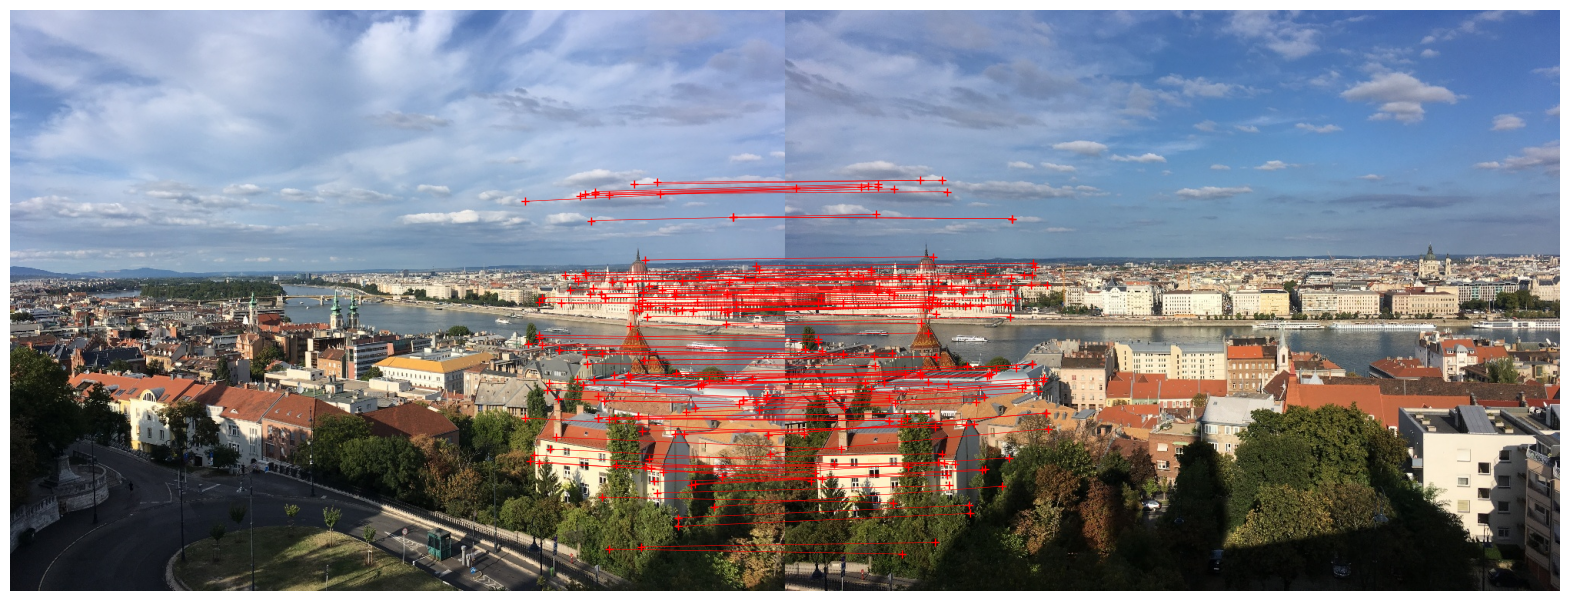

In [6]:
data = get_best_matches(img1, img2, 0.03)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, img1, img2, data)
fig.savefig('sift_match.pdf', bbox_inches='tight')

#### Part (4) performn RANSAC to get the homography and inliers

In [51]:
# display the inlier matching, report the average residual
# <YOUR CODE>
homography, max_inliers, best_model_errors = ransac(data, distance_threshold=20, outlier_ratio=0.2)
print("Average residual:", np.average(best_model_errors))
print("Inliers:", max_inliers)
print("The number of Inliers",len(max_inliers))
fig.savefig('ransac_match.pdf', bbox_inches='tight')

Average residual: 1.1045072540313905
Inliers: [[668.68237305 248.71894836  13.64976025 231.87284851]
 [669.69952393 530.43768311  23.98025513 550.87097168]
 [672.80828857 433.668396    24.92406464 441.04852295]
 [675.64447021 586.5201416   33.71586609 612.05847168]
 [680.72839355 578.58221436  39.02285004 602.64221191]
 [687.01324463 425.98809814  42.22286987 431.39337158]
 [687.25231934 588.79852295  47.26565933 609.55053711]
 [687.74481201 380.07226562  42.08116531 380.34402466]
 [688.02362061 422.68539429  43.01391983 427.82843018]
 [691.23242188 436.09988403  47.35260391 442.86697388]
 [691.79272461 373.98513794  46.57351303 373.83493042]
 [697.49475098 494.32296753  57.10153961 506.36676025]
 [700.87811279 485.23202515  60.67310333 495.96636963]
 [701.61804199 570.80200195  63.11942291 589.75073242]
 [709.1776123  555.47991943  71.88088226 571.07348633]
 [712.27038574 505.45178223  75.58863831 516.99389648]
 [713.74395752 442.27752686  75.43749237 447.52590942]
 [713.74395752 442.

#### Part (5) warp images to stitch them together

In [52]:
# display and report the stitching results
# <YOUR CODE>
# cv2.imwrite('stitched_images.jpg', im[:,:,::-1]*255., 
#             [int(cv2.IMWRITE_JPEG_QUALITY), 90])
im = warp_images(img1, img2, homography)
cv2.imwrite('stitched_images.jpg', im[:,:,::-1], [int(cv2.IMWRITE_JPEG_QUALITY), 90])

True

(97, 4)


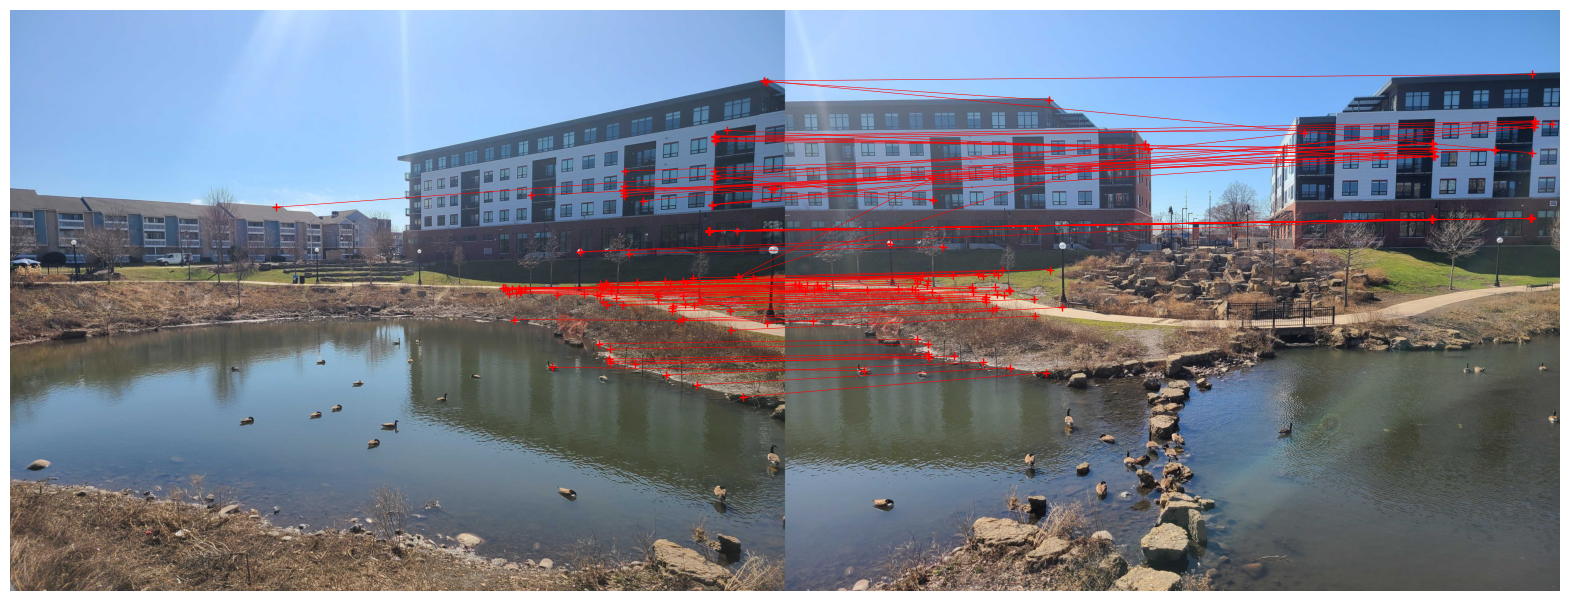

In [9]:
##Extra credits
extra1 = imread('./extra_credits/opt_01/park_left.jpg')
extra2 = imread('./extra_credits/opt_01/park_center.jpg')
extra3 = imread('./extra_credits/opt_01/park_right.jpg')

data_ex = get_best_matches(extra1, extra2, threshold=0.01)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, extra1, extra2, data_ex)
fig.savefig('sift_match_extra1.png', bbox_inches='tight')
data_ex = np.unique(data_ex, axis=0)
print(data_ex.shape)

(97, 4)


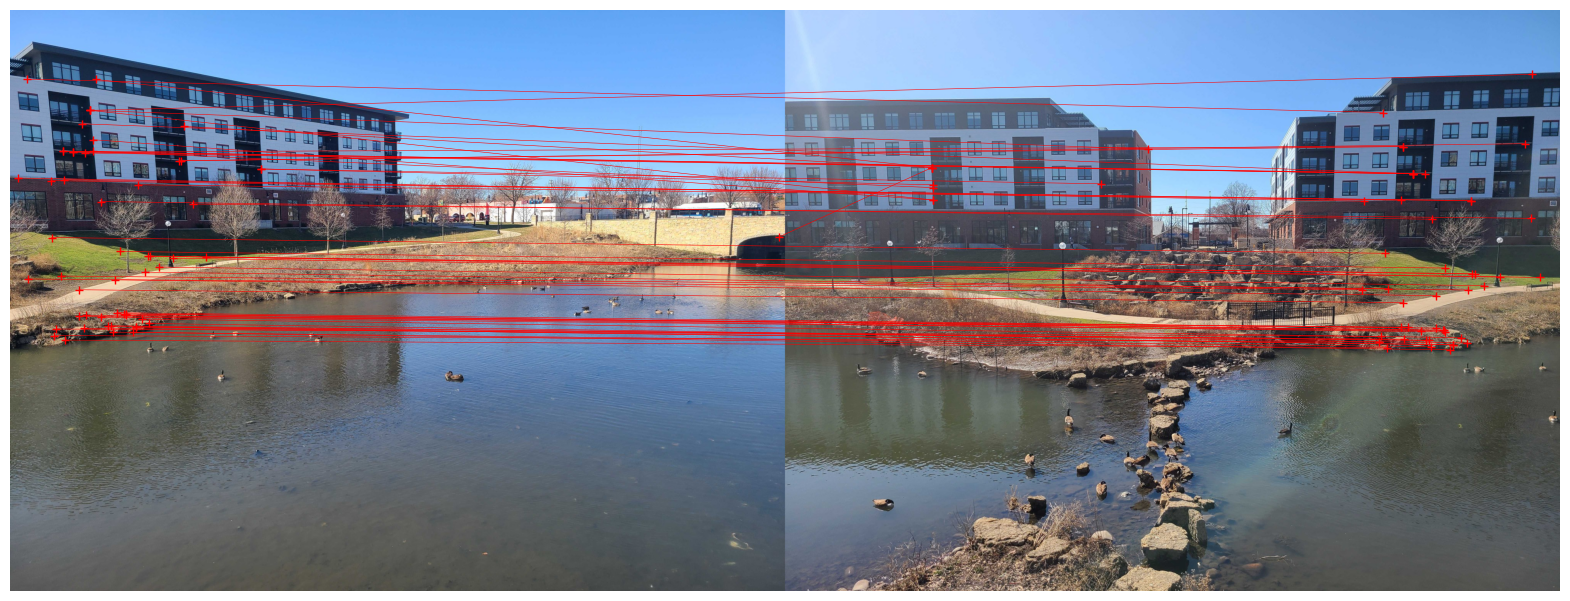

In [47]:
data_ex_2 = get_best_matches(extra3, extra2, threshold=0.01)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, extra3, extra2, data_ex_2)
fig.savefig('sift_match_extra2.png', bbox_inches='tight')
data_ex_2 = np.unique(data_ex, axis=0)
print(data_ex_2.shape)

In [66]:
homo1, max_inliers_ex, best_model_errors_ex = ransac(data_ex, distance_threshold=20, outlier_ratio=0.2)
print("Average residual of image 1:", np.average(best_model_errors_ex))
print("Inliers in image 1:", max_inliers_ex)

Average residual of image 1: 1.9630404874221667
Inliers in image 1: [[1282.34277344  723.28607178   26.81312752  715.21508789]
 [1287.92700195  723.82147217   35.92387009  715.53033447]
 [1291.89257812  728.04577637   41.4615593   720.50299072]
 [1298.29980469  738.03283691   50.47146988  732.11914062]
 [1304.40722656  724.97003174   57.95289612  716.31768799]
 [1309.82983398  805.41241455   71.27641296  809.8338623 ]
 [1315.94726562  735.84106445   74.83951569  728.78649902]
 [1323.08911133  725.80999756   83.74446869  716.59973145]
 [1326.96252441  733.52081299   88.3787384   726.13348389]
 [1329.28747559  731.7119751    91.92546844  723.18048096]
 [1339.73632812  725.95410156  106.70295715  716.04364014]
 [1410.54016113  929.87408447  205.9828949   937.94177246]
 [1422.90112305  740.23114014  212.30207825  728.92724609]
 [1482.05212402  628.74572754  272.40423584  607.83868408]
 [1492.02905273  739.81109619  293.01730347  725.86950684]
 [1525.42504883  740.48187256  328.94012451  72

In [67]:
im_e1 = warp_images(extra1, extra2, homo1)

In [70]:
cv2.imwrite('stitched_images_inter.jpg', im_e1[:,:,::-1], [int(cv2.IMWRITE_JPEG_QUALITY), 90])

True

In [7]:
im_e1 = imread('stitched_images_inter.jpg')

e:\Anaconda3\envs\env2\lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (105625634 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [12]:
data_ex3 = get_best_matches(extra3,im_e1, 0.03)
homo3, max_inliers, best_model_errors = ransac(data_ex3, distance_threshold=10, outlier_ratio=0.2)
im = warp_images(extra3,im_e1, homo3)
cv2.imwrite('stitched_images_finalextra.jpg', im[:,:,::-1], [int(cv2.IMWRITE_JPEG_QUALITY), 90])

C:\Users\Linxi Li\AppData\Local\Temp\ipykernel_8948\2983710499.py:110: RuntimeWarning: divide by zero encountered in true_divide
  transformed /= transformed[2, :, :]
C:\Users\Linxi Li\AppData\Local\Temp\ipykernel_8948\2983710499.py:110: RuntimeWarning: invalid value encountered in true_divide
  transformed /= transformed[2, :, :]
C:\Users\Linxi Li\AppData\Local\Temp\ipykernel_8948\2983710499.py:123: RuntimeWarning: overflow encountered in long_scalars
  new_height = max_y - min_y + 1
C:\Users\Linxi Li\AppData\Local\Temp\ipykernel_8948\2983710499.py:124: RuntimeWarning: overflow encountered in long_scalars
  new_width = max_x - min_x + 1


ValueError: negative dimensions are not allowed